In [2]:
import wandb
import time
import os
import utils
import warnings
import scipy
import sklearn
import torch
import torch_geometric
import pandas as pd
import numpy as np
import networkx as nx
import lightning.pytorch as pl
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass, field
from tsfresh import extract_features
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torchmetrics.classification import BinaryRecall, BinarySpecificity, AUROC
from sklearn.model_selection import StratifiedShuffleSplit
from mne_features.univariate import (
    compute_variance,
    compute_hjorth_complexity,
    compute_hjorth_mobility,
    compute_line_length,
    compute_higuchi_fd,
    compute_katz_fd,
)
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
from models import ClassicGCN, GATv2, GATv2Lightning
warnings.filterwarnings(
    "ignore", ".*does not have many workers.*"
)  ## DISABLED ON PURPOSE


/home/szymon/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch_geometric.seed_everything(42)

In [4]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [5]:
# TODO think about using kwargs argument here to specify args for dataloader
@dataclass
class SeizureDataLoader:
    npy_dataset_path: Path
    event_tables_path: Path
    plv_values_path: Path
    loso_patient: str = None
    sampling_f: int = 256
    seizure_lookback: int = 600
    sample_timestep: int = 5
    inter_overlap: int = 0
    preictal_overlap: int = 0
    ictal_overlap: int = 0
    self_loops: bool = True
    balance: bool = True
    train_test_split: float = None
    fft: bool = False
    hjorth: bool = False
    downsample: int = None
    buffer_time: int = 15
    batch_size: int = 32
    smote: bool = False
    tsfresh: bool = False
    rescale: bool = False
    used_classes_dict: dict[str] = field(
        default_factory=lambda: {"interictal": True, "preictal": True, "ictal": True}
    )
    """Class to prepare dataloaders for eeg seizure perdiction from stored files.

    Attributes:
        npy_dataset_path: (Path) Path to directory with .npy files
        event_tables_path: (Path) Path to directory with .csv files
        plv_values_path: (Path) Path to directory with .npy files
        loso_patient: (str) Patient name to be left out of training set.
    If None, no patient is left out for testing. (default: None)
        sampling_f: (int) Sampling frequency of the recordings. (default: 256)
        seizure_lookback: (int) Time in seconds to look back from seizure onset. (default: 600)
        sample_timestep: (int) Time in seconds between samples. (default: 5)
        inter_overlap: (int) Time in seconds to overlap between interictal samples. (default: 0)
        preictal_overlap: (int) Time in seconds to overlap between preictal samples. (default: 0)
        ictal_overlap: (int) Time in seconds to overlap between ictal samples. (default: 0)
        self_loops: (bool) Whether to add self loops to the graph. (default: True)
        balance: (bool) Whether to balance the classes. (default: True)
        train_test_split: (float) Percentage of data to be used for testing. (default: None)
        fft: (bool) Whether to use fft features. (default: False)
        hjorth: (bool) Whether to use hjorth features. (default: False)
        downsample: (int) Factor by which to downsample the data. (default: None)
        buffer_time: (int) Time in seconds to skip before and after every sample from seizure period. 
    (default: 15)
        batch_size: (int) Batch size for dataloaders. (default: 32)
        smote: (bool) Whether to use smote to balance the classes. (default: False)
        used_classes_ditct: (dict) Dictionary with classes to be used. 
    (default: {'interictal': True, 'preictal': True, 'ictal': True})

    
    """
    # if used_classes_dict is None:
    #     used_classes_dict = {"interictal": True, "preictal": True, "ictal": True}
    assert (fft and hjorth) == False, "When fft is True, hjorth should be False"
    assert (downsample is None) or (
        downsample > 0
    ), "Downsample should be None or positive integer"
    assert (train_test_split is None) or (
        train_test_split > 0 and train_test_split < 1
    ), "Train test split should be None or float between 0 and 1"

    assert not (smote and balance), "Cannot use smote and balance at the same time"
    assert not (
        (fft or hjorth) and tsfresh
    ), "Cannot use fft or hjorth and tsfresh at the same time"

    def _get_event_tables(self, patient_name: str) -> tuple[dict, dict]:
        """Read events for given patient into start and stop times lists from .csv extracted files.
        Args:
            patient_name: (str) Name of the patient to get events for.
        Returns:
            start_events_dict: (dict) Dictionary with start events for given patient.
            stop_events_dict: (dict) Dictionary with stop events for given patient.
        """

        event_table_list = os.listdir(self.event_tables_path)
        patient_event_tables = [
            os.path.join(self.event_tables_path, ev_table)
            for ev_table in event_table_list
            if patient_name in ev_table
        ]
        patient_event_tables = sorted(patient_event_tables)
        patient_start_table = patient_event_tables[
            0
        ]  ## done terribly, but it has to be so for win/linux compat
        patient_stop_table = patient_event_tables[1]
        start_events_dict = pd.read_csv(patient_start_table).to_dict("index")
        stop_events_dict = pd.read_csv(patient_stop_table).to_dict("index")
        return start_events_dict, stop_events_dict

    def _get_recording_events(self, events_dict, recording) -> list[int]:
        """Read seizure times into list from event_dict.
        Args:
            events_dict: (dict) Dictionary with events for given patient.
            recording: (str) Name of the recording to get events for.
        Returns:
            recording_events: (list) List of seizure event start and stop time for given recording.
        """
        recording_list = list(events_dict[recording + ".edf"].values())
        recording_events = [int(x) for x in recording_list if not np.isnan(x)]
        return recording_events

    def _get_graph(self, n_nodes: int) -> nx.Graph:
        """Creates Networx complete graph with self loops
        for given number of nodes.
        Args:
            n_nodes: (int) Number of nodes in the graph.
        Returns:
            graph: (nx.Graph) Complete graph with self loops.
        """
        graph = nx.complete_graph(n_nodes)
        self_loops = [[node, node] for node in graph.nodes()]
        graph.add_edges_from(self_loops)
        return graph

    def _get_edge_weights_recording(self, plv_values: np.ndarray) -> np.ndarray:
        """Method for extracting PLV values associated with given edges for a recording.
        The PLV was computed for the entire recroding for all channels when the recording was
        processed.
        Args:
            plv_values: (np.ndarray) Array with PLV values for given recording.
        Returns:
            edge_weights: (np.ndarray) Array with PLV values for given edges.
        """
        graph = self._get_graph(plv_values.shape[0])
        garph_dict = {}
        for edge in graph.edges():
            e_start, e_end = edge
            garph_dict[edge] = {"plv": plv_values[e_start, e_end]}
        nx.set_edge_attributes(graph, garph_dict)
        edge_weights = from_networkx(graph).plv.numpy()
        return edge_weights

    def _get_edges(self):
        """Method to assign edge attributes. Has to be called AFTER get_dataset() method."""
        graph = self._get_graph(self._features.shape[1])
        edges = np.expand_dims(from_networkx(graph).edge_index.numpy(), axis=0)
        edges_per_sample_train = np.repeat(
            edges, repeats=self._features.shape[0], axis=0
        )
        self._edges = torch.tensor(edges_per_sample_train)
        if self.loso_patient is not None:
            edges_per_sample_val = np.repeat(
                edges, repeats=self._loso_features.shape[0], axis=0
            )
            self._loso_edges = torch.tensor(edges_per_sample_val)

    def _array_to_tensor(self):
        """Method converting features, edges and weights to torch.tensors"""

        self._features = torch.from_numpy(self._features)
        self._labels = torch.from_numpy(self._labels)
        # self._time_labels = torch.from_numpy(self._time_labels)
        self._edge_weights = torch.from_numpy(self._edge_weights)
        if self.loso_patient is not None:
            self._loso_features = torch.from_numpy(self._loso_features)
            self._loso_labels = torch.from_numpy(self._loso_labels)
            # self._loso_time_labels = torch.from_numpy(self._loso_time_labels)
            self._loso_edge_weights = torch.from_numpy(self._loso_edge_weights)

    def _get_labels_count(self):
        """Convenience method to get counts of labels in the dataset."""
        labels, counts = np.unique(self._labels, return_counts=True)
        self._label_counts = {}
        for n, label in enumerate(labels):
            self._label_counts[int(label)] = counts[n]
        if self.loso_patient is not None:
            labels, counts = np.unique(self._loso_labels, return_counts=True)
            self._val_label_counts = {}
            for n, label in enumerate(labels):
                self._val_label_counts[int(label)] = counts[n]

    def _calculate_hjorth_features(self, features):
        """Converting features to Hjorth features.
        Args:
            features: (np.ndarray) Array with features to be converted.
        Returns:
            new_features: (np.ndarray) Array with Hjorth features.
        """
        new_features = np.array(
            [
                np.concatenate(
                    [
                        np.expand_dims(compute_variance(feature), 1),
                        np.expand_dims(compute_hjorth_mobility(feature), 1),
                        np.expand_dims(compute_hjorth_complexity(feature), 1),
                        np.expand_dims(compute_line_length(feature), 1),
                        np.expand_dims(compute_katz_fd(feature), 1),
                        np.expand_dims(compute_higuchi_fd(feature), 1),
                    ],
                    axis=1,
                )
                for feature in features
            ]
        )
        # new_mean = new_features.mean(axis=0)
        # new_std = new_features.std(axis=0)
        # new_features = (new_features - new_mean) / new_std
        return new_features

    def _features_to_data_list(self, features, edges, labels, edge_weights=None):
        """Converts features, edges and labels to list of torch_geometric.data.Data objects.
        Args:
            features: (np.ndarray) Array with features.
            edges: (np.ndarray) Array with edges.
            labels: (np.ndarray) Array with labels.
        Returns:
            data_list: (list) List of torch_geometric.data.Data objects.
        """
        data_list = [
            Data(
                x=features[i],
                edge_index=edges[i],
                edge_attr=edge_weights[i],
                y=labels[i],
                # time=time_label[i],
            )
            for i in range(len(features))
        ]
        return data_list

    def _split_data_list(self, data_list):
        """Methods for splitting list of torch_geometric.data.Data objects into train and validation sets.
        Uses StratifiedShuffleSplit to ensure that the classes are balanced in both sets.
        Args:
            data_list: (list) List of torch_geometric.data.Data objects.
        Returns:
            data_list_train: (list) List of torch_geometric.data.Data objects for training.
            dataset_list_val: (list) List of torch_geometric.data.Data objects for validation.
        """
        class_labels = torch.tensor(
            [data.y.item() for data in data_list], dtype=torch.float32
        ).unsqueeze(1)
        patient_labels = torch.tensor(
            np.expand_dims(self._patient_number, 1), dtype=torch.float32
        )
        class_labels_patient_labels = torch.cat([class_labels, patient_labels], dim=1)
        splitter = StratifiedShuffleSplit(
            n_splits=1, test_size=self.train_test_split, random_state=42
        )
        train_indices, val_indices = next(
            splitter.split(data_list, class_labels_patient_labels)
        )
        self._indexes_to_later_delete = {"train": train_indices, "val": val_indices}
        data_list_train = [data_list[i] for i in train_indices]
        dataset_list_val = [data_list[i] for i in val_indices]
        return data_list_train, dataset_list_val

    def _initialize_dicts(self):
        """Temporary method to initialize dictionaries for storing features, labels, etc.
        Looks terrible, but convenient so far.
        """
        self._features_dict = {}
        self._labels_dict = {}
        self._time_labels_dict = {}
        self._edge_weights_dict = {}
        self._patient_number_dict = {}
        if self.loso_patient:
            self._loso_features_dict = {}
            self._loso_labels_dict = {}
            self._loso_time_labels_dict = {}
            self._loso_edge_weights_dict = {}
            self._loso_patient_number_dict = {}

    def _convert_dict_to_array(self):
        """A method to convert dictionaries to numpy arrays. This approach with dicts is redundant,
        but allows for joblib parallelization for data loading by not using concatenation in the loading loop.
        """
        self._features = np.concatenate(
            [self._features_dict[key] for key in self._features_dict.keys()]
        )
        del self._features_dict
        self._labels = np.concatenate(
            [self._labels_dict[key] for key in self._labels_dict.keys()]
        )
        del self._labels_dict
        # self._time_labels = np.concatenate(
        #     [self._time_labels_dict[key] for key in self._time_labels_dict.keys()]
        # )
        # del self._time_labels_dict
        self._edge_weights = np.concatenate(
            [self._edge_weights_dict[key] for key in self._edge_weights_dict.keys()]
        )
        del self._edge_weights_dict
        self._patient_number = np.concatenate(
            [self._patient_number_dict[key] for key in self._patient_number_dict.keys()]
        )
        del self._patient_number_dict
        if self.loso_patient:
            self._loso_features = np.concatenate(
                [self._loso_features_dict[key] for key in self._loso_features_dict.keys()]
            )
            del self._loso_features_dict
            self._loso_labels = np.concatenate(
                [self._loso_labels_dict[key] for key in self._loso_labels_dict.keys()]
            )
            del self._loso_labels_dict
            # self._loso_time_labels = np.concatenate(
            #     [
            #         self._loso_time_labels_dict[key]
            #         for key in self._loso_time_labels_dict.keys()
            #     ]
            # )
            # del self._loso_time_labels_dict
            self._loso_edge_weights = np.concatenate(
                [
                    self._loso_edge_weights_dict[key]
                    for key in self._loso_edge_weights_dict.keys()
                ]
            )
            del self._loso_edge_weights_dict
            self._loso_patient_number = np.concatenate(
                [
                    self._loso_patient_number_dict[key]
                    for key in self._loso_patient_number_dict.keys()
                ]
            )
            del self._loso_patient_number_dict

    def _balance_classes(self):
        """Method to balance classes in the dataset by removing samples from the majority class.
        Currently works only for interictal and ictal classes."""
        negative_label = self._label_counts[0]
        positive_label = self._label_counts[1]

        print(f"Number of negative samples pre removal {negative_label}")
        print(f"Number of positive samples pre removal {positive_label}")
        imbalance = negative_label - positive_label
        print(f"imbalance {imbalance}")
        negative_indices = np.where(self._labels == 0)[0]
        indices_to_discard = np.random.choice(
            negative_indices, size=imbalance, replace=False
        )

        self._features = np.delete(self._features, obj=indices_to_discard, axis=0)
        self._labels = np.delete(self._labels, obj=indices_to_discard, axis=0)
        self._time_labels = np.delete(self._time_labels, obj=indices_to_discard, axis=0)
        self._edge_weights = np.delete(
            self._edge_weights, obj=indices_to_discard, axis=0
        )
        self._patient_number = np.delete(
            self._patient_number, obj=indices_to_discard, axis=0
        )

    def _standardize_data(self, features, labels, loso_features=None):
        """Standardize features by subtracting mean and dividing by standard deviation.
        The mean and std are computed from the interictal class. The same values are used for loso_features.
        Args:
            features: (np.ndarray) Array with features.
            labels: (np.ndarray) Array with labels.
            loso_features (optional): (np.ndarray) Array with features for LOSO patient.
        """
        indexes = np.where(labels == 0)[0]
        features_negative = features[indexes]
        channel_mean = features_negative.mean()
        channel_std = features_negative.std()
        for i in range(features.shape[0]):
            for n in range(features.shape[1]):
                features[i, n, :] = (features[i, n, :] - channel_mean) / channel_std
        if (
            loso_features is not None
        ):  ## standardize loso features with the same values as for training data
            for i in range(loso_features.shape[0]):
                for n in range(loso_features.shape[1]):
                    loso_features[i, n, :] = (
                        loso_features[i, n, :] - channel_mean
                    ) / channel_std

    def _min_max_scale(self, features, labels, loso_features=None):
        """Min max scale features to range [0,1]. The min and max values are computed from the interictal class.
        Args:
            features: (np.ndarray) Array with features.
            labels: (np.ndarray) Array with labels.
        """
        indexes = np.where(labels == 0)[0]
        features_negative = features[indexes]

        channel_min = features_negative.min()
        channel_max = features_negative.max()
        for i in range(features.shape[0]):
            for n in range(features.shape[1]):
                features[i, n, :] = (features[i, n, :] - channel_min) / (
                    channel_max - channel_min
                )
        if loso_features is not None:
            for i in range(loso_features.shape[0]):
                for n in range(loso_features.shape[1]):
                    loso_features[i, n, :] = (loso_features[i, n, :] - channel_min) / (
                        channel_max - channel_min
                    )

    def _apply_smote(self, features, labels):
        """Performs SMOTE oversampling on the dataset. Implemented for preictal vs ictal scenarion only.
        Args:
            features: (np.ndarray) Array with features.
            labels: (np.ndarray) Array with labels.
        Returns:
            x_train_smote: (np.ndarray) Array with SMOTE oversampled features.
            y_train_smote: (np.ndarray) Array with SMOTE oversampled labels.
        """
        dim_1, dim_2, dim_3 = features.shape

        new_dim = dim_1 * dim_2
        new_x_train = features.reshape(new_dim, dim_3)
        new_y_train = []
        for i in range(len(labels)):
            new_y_train.extend([labels[i]] * dim_2)

        new_y_train = np.array(new_y_train)

        # transform the dataset
        oversample = SMOTE(random_state=42)
        x_train, y_train = oversample.fit_resample(new_x_train, new_y_train)
        x_train_smote = x_train.reshape(int(x_train.shape[0] / dim_2), dim_2, dim_3)
        y_train_smote = []
        for i in range(int(x_train.shape[0] / dim_2)):
            # print(i)
            value_list = list(y_train.reshape(int(x_train.shape[0] / dim_2), dim_2)[i])
            # print(list(set(value_list)))
            y_train_smote.extend(list(set(value_list)))
            ## Check: if there is any different value in a list
            if len(set(value_list)) != 1:
                print(
                    "\n\n********* STOP: THERE IS SOMETHING WRONG IN TRAIN ******\n\n"
                )
        y_train_smote = np.array(y_train_smote)
        # print(np.unique(y_train_smote,return_counts=True))
        return x_train_smote, y_train_smote

    def _compute_tsfresh_features(self, features):
        """Compute tsfresh features for given features. The features are computed for each channel in every sample.
        Currently the extracted features are hardcoded into the method.
        Args:
            features: (np.ndarray) Array with features.
        Returns:
            new_features: (np.ndarray) Array with tsfresh features.
        """
        fc_parameters = {
            "abs_energy": None,
            "absolute_sum_of_changes": None,
            "agg_autocorrelation": [{"f_agg": "mean", "maxlag": 10}],
            "autocorrelation": [{"lag": 10}],
            "number_peaks": [{"n": 5}],
            "c3": [{"lag": 10}],
            "cid_ce": [{"normalize": True}],
            "longest_strike_below_mean": None,
            "longest_strike_above_mean": None,
            "fourier_entropy": [{"bins": 10}],
            "mean_change": None,
            "number_crossing_m": [{"m": 0}],
            "sample_entropy": None,
            "variance": None,
            "variation_coefficient": None,
        }
        n_variables = len(fc_parameters.keys())
        n_nodes = features[0].shape[0]
        for n, case in enumerate(features):
            new_dataframe = pd.DataFrame(columns=["id", "time", "channel", "value"])
            new_dataframe["id"] = np.repeat(n, case.shape[0] * case.shape[1])
            new_dataframe["time"] = np.tile(np.arange(case.shape[1]), case.shape[0])
            new_dataframe["channel"] = np.stack(
                [torch.full([case.shape[1]], i) for i in range(case.shape[0])]
            ).flatten()
            new_dataframe["value"] = abs(case.flatten())
            extracted_features = extract_features(
                new_dataframe,
                column_id="id",
                column_sort="time",
                column_kind="channel",
                column_value="value",
                default_fc_parameters=fc_parameters,
                n_jobs=6,
            )

            try:
                final_df = pd.concat([final_df, extracted_features], axis=0)
            except:
                final_df = extracted_features
        new_features = final_df.to_numpy().reshape(-1, n_nodes, n_variables)
        return new_features

    def _extend_data(
        self,
        patient,
        patient_number,
        features,
        labels,
        time_labels=None,
        plv_edge_weights=None,
    ):
        """Convenience method to extend the dictionaries with features, labels, time labels and edge weights.
        Args:
            patient: (str) Name of the patient to extend the dictionaries for.
            patient_number: (int) Patient number to extend the dictionaries for.
            features: (np.ndarray) Array with features.
            labels: (np.ndarray) Array with labels.
            time_labels (optional): (np.ndarray) Array with time labels.
            plv_edge_weights (optional): (np.ndarray) Array with edge weights.
        """
        if patient == self.loso_patient:
            # logging.info(f"Adding recording {record} of patient {patient}")
            try:
                self._loso_features_dict[patient] = np.concatenate(
                    (self._loso_features_dict[patient], features), axis=0
                )
                self._loso_labels_dict[patient] = np.concatenate(
                    (self._loso_labels_dict[patient], labels), axis=0
                )
                # self._loso_time_labels_dict[patient] = np.concatenate(
                #     (self._loso_time_labels_dict[patient], time_labels), axis=0
                # )
                self._loso_edge_weights_dict[patient] = np.concatenate(
                    (
                        self._loso_edge_weights_dict[patient],
                        np.repeat(plv_edge_weights, features.shape[0], axis=0),
                    )
                )

                self._loso_patient_number_dict[patient] = np.concatenate(
                    (self._loso_patient_number_dict[patient], patient_number)
                )
            except:
                self._loso_features_dict[patient] = features
                self._loso_labels_dict[patient] = labels
                # self._loso_time_labels_dict[patient] = time_labels
                self._loso_edge_weights_dict[patient] = np.repeat(
                    plv_edge_weights, features.shape[0], axis=0
                )
                self._loso_patient_number_dict[patient] = patient_number

        else:
            try:
                self._features_dict[patient] = np.concatenate(
                    (self._features_dict[patient], features), axis=0
                )
                self._labels_dict[patient] = np.concatenate(
                    (self._labels_dict[patient], labels), axis=0
                )
                # self._time_labels_dict[patient] = np.concatenate(
                #     (self._time_labels_dict[patient], time_labels), axis=0
                # )
                self._edge_weights_dict[patient] = np.concatenate(
                    (
                        self._edge_weights_dict[patient],
                        np.repeat(plv_edge_weights, features.shape[0], axis=0),
                    )
                )

                self._patient_number_dict[patient] = np.concatenate(
                    (self._patient_number_dict[patient], patient_number)
                )
            except:
                self._features_dict[patient] = features
                self._labels_dict[patient] = labels
                # self._time_labels_dict[patient] = time_labels
                self._edge_weights_dict[patient] = np.repeat(
                    plv_edge_weights, features.shape[0], axis=0
                )
                self._patient_number_dict[patient] = patient_number

    def _get_labels_features_edge_weights_seizure(self, patient):
        """Method to extract features, labels and edge weights for seizure and interictal samples."""

        event_tables = self._get_event_tables(
            patient
        )  # extract start and stop of seizure for patient
        patient_path = os.path.join(self.npy_dataset_path, patient)
        recording_list = [
            recording
            for recording in os.listdir(patient_path)
            if "seizures" in recording
        ]
        for record in recording_list:  # iterate over recordings for a patient
            recording_path = os.path.join(patient_path, record)
            record = record.replace(
                "seizures_", ""
            )  ## some magic to get it properly working with event tables
            record_id = record.split(".npy")[0]  #  get record id
            start_event_tables = self._get_recording_events(
                event_tables[0], record_id
            )  # get start events
            stop_event_tables = self._get_recording_events(
                event_tables[1], record_id
            )  # get stop events
            data_array = np.load(recording_path)  # load the recording

            plv_edge_weights = np.expand_dims(
                self._get_edge_weights_recording(
                    np.load(os.path.join(self.plv_values_path, patient, record))
                ),
                axis=0,
            )

            features, labels, time_labels = utils.extract_training_data_and_labels(
                data_array,
                start_event_tables,
                stop_event_tables,
                fs=self.sampling_f,
                seizure_lookback=self.seizure_lookback,
                sample_timestep=self.sample_timestep,
                preictal_overlap=self.preictal_overlap,
                ictal_overlap=self.ictal_overlap,
                buffer_time=self.buffer_time,
            )

            if features is None:
                print(
                    f"Skipping the recording {record} patients {patient} cuz features are none"
                )
                continue

            features = features.squeeze(2)

            if self.downsample:
                new_sample_count = int(self.downsample * self.sample_timestep)
                features = scipy.signal.resample(features, new_sample_count, axis=2)
            if self.fft:
                features = np.fft.rfft(features, axis=2)
            if self.smote:
                features, labels = self._apply_smote(features, labels)
           # time_labels = np.expand_dims(time_labels.astype(np.int32), 1)
            labels = labels.reshape((labels.shape[0], 1)).astype(np.float32)
            patient_number = torch.full(
                [labels.shape[0]],
                int("".join(x for x in patient if x.isdigit())),
                dtype=torch.float32,
            )

            self._extend_data(patient, patient_number, features, labels, plv_edge_weights=plv_edge_weights)

    def _get_labels_features_edge_weights_interictal(
        self, patient, samples_patient: int = None
    ):
        """Method to extract features, labels and edge weights for interictal samples.
        Args:
            patient: (str) Name of the patient to extract the data for.
            samples_patient (optional): (int) Number of samples to extract for a patient.
        Samples are extracted from non-seizure recordings for a patient, starting from random time point.
        If not specified, the number of samples is calculated as the number of interictal samples for a patient
        divided by the number of recordings for a patient.

        """
        patient_path = os.path.join(self.npy_dataset_path, patient)
        ## get all non-seizure recordings for a patient
        recording_list = [
            recording
            for recording in os.listdir(patient_path)
            if not "seizures_" in recording
        ]
        if samples_patient is None:
            patient_num = int("".join(filter(str.isdigit, patient)))
            if patient == self.loso_patient:
                patient_negatives = np.unique(
                    self._loso_labels_dict[patient], return_counts=True
                )[1][0]
                samples_per_recording = int(patient_negatives / len(recording_list))
            else:
                patient_negatives = np.unique(
                    self._labels_dict[patient], return_counts=True
                )[1][0]
                samples_per_recording = int(patient_negatives / len(recording_list))
        else:
            samples_per_recording = int(samples_patient / len(recording_list))
        for recording in recording_list:
            recording_path = os.path.join(patient_path, recording)
            data_array = np.expand_dims(np.load(recording_path), 1)
            try:
                features, labels = utils.extract_training_data_and_labels_interictal(
                    input_array=data_array,
                    samples_per_recording=samples_per_recording,
                    fs=self.sampling_f,
                    timestep=self.sample_timestep,
                    overlap=self.inter_overlap,
                )
            except:
                print(f"Skipping recording {recording} for patient due to the error")
                continue
            idx_to_delete = np.where(
                np.array([np.diff(feature, axis=-1).mean() for feature in features])
                == 0
            )[0]
            if len(idx_to_delete) > 0:
                features = np.delete(features, obj=idx_to_delete, axis=0)
                labels = np.delete(labels, obj=idx_to_delete, axis=0)
                print(
                    f"Deleted {len(idx_to_delete)} samples from patient {patient} \n recording {recording} due to zero variance"
                )
            patient_number = torch.full(
                [labels.shape[0]],
                patient_num,
                dtype=torch.float32,
            )
            features = features.squeeze(2)
            if self.downsample:
                new_sample_count = int(self.downsample * self.sample_timestep)
                features = scipy.signal.resample(features, new_sample_count, axis=2)
            if self.fft:
                features = np.fft.rfft(features, axis=2)
            labels = labels.reshape((labels.shape[0], 1)).astype(np.float32)
            self._extend_data(patient, patient_number, features, labels)

    def _update_classes(self):
        """Method to remove samples of period that we do not want to load, as specified in used_classes_dict.
        If it is possible, the method aims set the interictal period as class 0 to be used for extracting normalization parameters.
        If it is not possible, preictal period remains chosen as class 0.
        """
        if (
            not self.used_classes_dict["ictal"]
            or not self.used_classes_dict["preictal"]
        ):
            label_to_delete = 0 if self.used_classes_dict["ictal"] else 1
            idx_to_delete = np.where(self._labels == label_to_delete)[0]
            self._features = np.delete(self._features, obj=idx_to_delete, axis=0)
            self._labels = np.delete(self._labels, obj=idx_to_delete, axis=0)
            self._patient_number = np.delete(
                self._patient_number, obj=idx_to_delete, axis=0
            )
            ## change labels of remaining classes
            if label_to_delete == 0:
                self._labels[self._labels == 2] = 0
                print(
                    "Deleted preictal samples, changed interictal label to 0,  ictal remains 1 "
                )
            else:
                self._labels[self._labels == 0] = 1
                self._labels[self._labels == 2] = 0
                print(
                    "Deleted ictal samples, changed interictal label to 0, preictal to 1"
                )
            if self.loso_patient is not None:
                idx_to_delete = np.where(self._loso_labels == label_to_delete)[0]
                self._loso_features = np.delete(
                    self._loso_features, obj=idx_to_delete, axis=0
                )
                self._loso_labels = np.delete(
                    self._loso_labels, obj=idx_to_delete, axis=0
                )
                self._loso_patient_number = np.delete(
                    self._loso_patient_number, obj=idx_to_delete, axis=0
                )
                if label_to_delete == 0:
                    self._loso_labels[self._loso_labels == 2] = 0
                    print(
                        "Deleted preictal samples from LOSO patient, changed interictal label to 0, ictal remains 1 "
                    )
                else:
                    self._loso_labels[self._loso_labels == 0] = 1
                    self._loso_labels[self._loso_labels == 2] = 0
                    print(
                        "Deleted ictal from LOSO patient, changed interictal label to 0, preictal to 1"
                    )
        elif (
            sum(self.used_classes_dict.values()) == 3
        ):  ## case when all three classes are used - just flipping labels
            self._labels[
                self._labels == 2
            ] = 4  ## change interictal to 4 from 2 temporarily
            self._labels[self._labels == 0] = 2  ## change preictal to 2 from 0
            self._labels[self._labels == 4] = 0  ## change interictal to 0 from 4
            if self.loso_patient is not None:
                self._loso_labels[self._loso_labels == 2] = 4
                self._loso_labels[self._loso_labels == 0] = 2
                self._loso_labels[self._loso_labels == 4] = 0

    # TODO define a method to create edges and calculate plv to get weights
    def get_dataset(self):
        """Creating graph data iterators. The iterator yelds dynamic, weighted and undirected graphs
        containing self loops. Every node represents one electrode in EEG. The graph is fully connected,
        edge weights are calculated for every EEG recording as PLV between channels (edge weight describes
        the "strength" of connectivity between two channels in a recording). Node features are values of
        channel voltages in time. Features are of shape [nodes,features,timesteps].

        Returns:
            train_dataset {DynamicGraphTemporalSignal} -- Training data iterator.
            valid_dataset {DynamicGraphTemporalSignal} -- Validation data iterator (only if loso_patient is
            specified in class constructor).
        """
        ### TODO rozkminić o co chodzi z tym całym time labels - na razie wartość liczbowa która tam wchodzi
        ### to shape atrybutu time_labels
        assert (
            "interictal" in self.used_classes_dict.keys()
        ), "Please define the behavior for interictal class in used_classes_dict"
        assert (
            "preictal" in self.used_classes_dict.keys()
        ), "Please define the behavior for preictal class in used_classes_dict"
        assert (
            "ictal" in self.used_classes_dict.keys()
        ), "Please define the behavior for ictal class in used_classes_dict"

        assert (
            sum(self.used_classes_dict.values()) > 1
        ), "Please define at least two classes to use in used_classes_dict"

        self._initialize_dicts()
        patient_list = os.listdir(self.npy_dataset_path)
        start_time = time.time()
        if self.smote:
            for patient in patient_list:
                self._get_labels_features_edge_weights_seizure(patient)
        else:
            Parallel(n_jobs=6, require="sharedmem")(
                delayed(self._get_labels_features_edge_weights_seizure)(patient)
                for patient in patient_list
            )
        print(
            f"Finished reading in {time.time() - start_time} seconds for seizure data"
        )
        if self.used_classes_dict["interictal"]:
            Parallel(n_jobs=6, require="sharedmem")(
                delayed(self._get_labels_features_edge_weights_interictal)(patient)
                for patient in patient_list
            )

        self._convert_dict_to_array()
        self._update_classes()

        self._get_labels_count()

        if self.balance:
            self._balance_classes()

        print(
            f"Finished reading in {time.time() - start_time} seconds for non seizure data"
        )
        start_time_preprocessing = time.time()
        if self.rescale:
            self._features *= (
                self._features * 1e6
            )  ## rescale to back to volts, numeric stability problems
            if self.loso_patient is not None:
                self._loso_features *= self._loso_features * 1e6
        self._standardize_data(self._features, self._labels, self._loso_features)
        if self.tsfresh:
            self._features = self._compute_tsfresh_features(self._features)
            if self.loso_patient is not None:
                self._loso_features = self._compute_tsfresh_features(self._loso_features)

        if self.hjorth:
            self._features = self._calculate_hjorth_features(self._features)
            if self.loso_patient is not None:
                self._loso_features = self._calculate_hjorth_features(self._loso_features)
        self._get_edges()
        self._array_to_tensor()

        if self.train_test_split is not None:
            if self.fft or self.hjorth:
                data_list = self._features_to_data_list(
                    self._features,
                    self._edges,
                    self._labels,
                    self._edge_weights,
                    # self._time_labels,
                )
                train_data_list, val_data_list = self._split_data_list(data_list)
                label_count = np.unique(
                    [data.y.item() for data in train_data_list], return_counts=True
                )[1]
                self.alpha = label_count[0] / label_count[1]
                loaders = [
                    DataLoader(
                        train_data_list,
                        batch_size=self.batch_size,
                        shuffle=True,
                        drop_last=False,
                    ),
                    DataLoader(
                        val_data_list,
                        batch_size=len(val_data_list),
                        shuffle=False,
                        drop_last=False,
                    ),
                ]

            else:
                train_dataset = torch.utils.data.TensorDataset(
                    self._features,
                    self._edges,
                    self._edge_weights,
                    self._labels,
                    # self._time_labels,
                )

                train_dataset, val_dataset = torch.utils.data.random_split(
                    train_dataset,
                    [1 - self.train_test_split, self.train_test_split],
                    generator=torch.Generator().manual_seed(42),
                )

                train_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=self.batch_size,
                    shuffle=True,
                    drop_last=False,
                )

                val_dataloader = torch.utils.data.DataLoader(
                    val_dataset,
                    batch_size=self.batch_size,
                    shuffle=False,
                    drop_last=False,
                )
                loaders = [train_dataloader, val_dataloader]
        else:
            if self.fft or self.hjorth:
                train_data_list = self._features_to_data_list(
                    self._features,
                    self._edges,
                    self._labels,
                    self._edge_weights,
                    # self._time_labels,
                )
                loaders = [
                    DataLoader(
                        train_data_list,
                        batch_size=self.batch_size,
                        shuffle=True,
                        drop_last=False,
                    )
                ]
            else:
                train_dataset = torch.utils.data.TensorDataset(
                    self._features,
                    self._edges,
                    self._edge_weights,
                    self._labels,
                    # self._time_labels,
                )
                train_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=self.batch_size,
                    shuffle=True,
                    drop_last=False,
                )
                loaders = [train_dataloader]
        if self.loso_patient:
            if self.fft or self.hjorth:
                loso_data_list = self._features_to_data_list(
                    self._loso_features,
                    self._loso_edges,
                    self._loso_labels,
                    self._loso_edge_weights,
                    # self._loso_time_labels,
                )
                print("Preprocessing time: ", time.time() - start_time_preprocessing)
                return (
                    *loaders,
                    DataLoader(
                        loso_data_list,
                        batch_size=len(loso_data_list),
                        shuffle=False,
                        drop_last=False,
                    ),
                )
            loso_dataset = torch.utils.data.TensorDataset(
                self._loso_features,
                self._loso_edges,
                self._loso_labels,
                self._loso_edge_weights,
                #  self._loso_time_labels,
            )
            loso_dataloader = torch.utils.data.DataLoader(
                loso_dataset,
                batch_size=self.batch_size,
                shuffle=False,
                drop_last=False,
            )

            return (*loaders, loso_dataloader)

        return (*loaders,)

In [7]:
torch_geometric.seed_everything(42)
TIMESTEP = 6
PREICTAL_OVERLAP = 0
ICTAL_OVERLAP = 0
INTER_OVERLAP = 0
SFREQ = 256
torch_geometric.seed_everything(42)
dataloader = SeizureDataLoader(
    npy_dataset_path=Path('data/npy_data_full'),
    event_tables_path=Path('data/event_tables'),
    plv_values_path=Path('data/plv_arrays'),
    loso_patient='chb06',
    sampling_f=SFREQ,
    seizure_lookback=600,
    sample_timestep= TIMESTEP,
    inter_overlap=INTER_OVERLAP,
    preictal_overlap=PREICTAL_OVERLAP,
    ictal_overlap=ICTAL_OVERLAP,
    self_loops=False,
    balance=False,
    train_test_split=0.05,
    fft=False,
    hjorth=False,
    downsample=60,
    batch_size=64,
    buffer_time=60,
    smote=False,
    tsfresh=False,
    rescale=False,
    used_classes_dict={"ictal": True, "interictal": False, "preictal": True}
    )
train_loader,valid_loader, loso_loader =dataloader.get_dataset() 
alpha = list(dataloader._label_counts.values())[0]/list(dataloader._label_counts.values())[1]
alpha

Skipping the recording chb20_12.npy patients chb20 cuz features are none
Finished reading in 13.327615976333618 seconds for seizure data
Finished reading in 13.536434173583984 seconds for non seizure data


8.6

In [109]:
edge_weights = dataloader._edge_weights[0].numpy()
features = dataloader._features[543].numpy()

In [119]:
from utils import plv_connectivity
from mne_features.bivariate import compute_phase_lock_val, compute_spect_corr

In [124]:
plv_conn_classic = plv_connectivity(features.shape[0],features)
plv_conn_mne = compute_phase_lock_val(features)
spectral_corr = compute_spect_corr(60,features,with_eigenvalues=False)

PLV in process.....


In [85]:
connectivity_vector = plv_conn_classic[np.triu_indices(plv_conn_classic.shape[0],k=1)]

In [127]:
n = int(np.sqrt(2 * len(spectral_corr)))+1

# Reshape the flattened array into a square matrix
upper_triangular = np.zeros((n, n))
upper_triangular[np.triu_indices(n, k=1)] = spectral_corr

# Create an empty matrix for the complete symmetric matrix
symmetric_matrix = np.zeros((n, n))

# Fill the upper triangular part (including the diagonal)
symmetric_matrix[np.triu_indices(n)] = upper_triangular[np.triu_indices(n)]

# Fill the lower triangular part by mirroring the upper triangular
symmetric_matrix = symmetric_matrix + symmetric_matrix.T - np.diag(np.diag(symmetric_matrix))

# Add 1 to the diagonal elements
np.fill_diagonal(symmetric_matrix, 1)

In [149]:
result_graph = nx.graph.Graph()
plv_th = 0.0
result_graph.add_nodes_from(range(features.shape[0]))
for i in range(features.shape[0]):
    for j in range(i+1,features.shape[0]):
        if symmetric_matrix[i,j] > plv_th:
            result_graph.add_edge(i,j,weight=symmetric_matrix[i,j])
def add_self_loops(graph):
    for node in graph.nodes:
        graph.add_edge(node,node,weight=1)
    return graph
result_graph = add_self_loops(result_graph)

In [150]:
from_networkx(result_graph)

Data(edge_index=[2, 130], weight=[130], num_nodes=18)

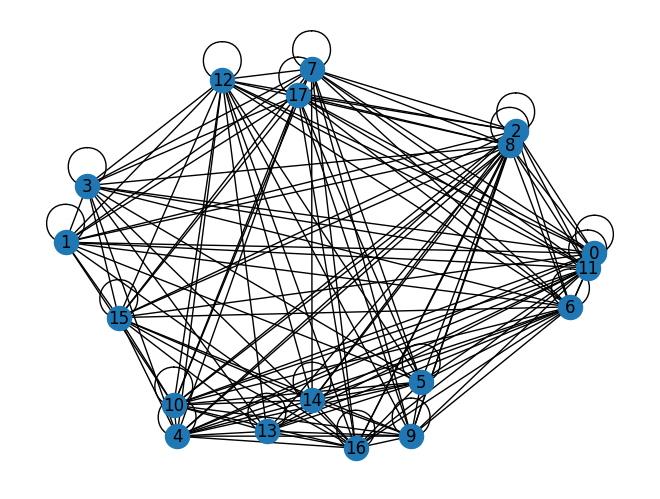

In [138]:
nx.draw(result_graph,with_labels=True)

In [27]:
edge_weights

array([0.52681424, 0.40549672, 0.4839093 , 0.44410112, 0.42193592,
       0.42432111, 0.43841387, 0.42328377, 0.42582926, 0.42422416,
       0.41494357, 0.41132123, 0.42188202, 0.47519718, 0.45446516,
       0.43954295, 0.47054342, 1.        , 0.52681424, 0.42446241,
       0.42569123, 0.4070992 , 0.43484083, 0.41440436, 0.42072517,
       0.42778546, 0.42315338, 0.4306152 , 0.414569  , 0.42494398,
       0.4144178 , 0.41642154, 0.4387638 , 0.40495631, 0.42379228,
       1.        , 0.40549672, 0.42446241, 0.41285536, 0.40701376,
       0.40646392, 0.41964582, 0.43205618, 0.4376769 , 0.40481579,
       0.41030448, 0.40508908, 0.46075533, 0.4203575 , 0.40485383,
       0.40969497, 0.42185694, 0.5342662 , 1.        , 0.4839093 ,
       0.42569123, 0.41285536, 0.41106582, 0.41721976, 0.43691604,
       0.43255533, 0.44518087, 0.42444581, 0.41139799, 0.4349807 ,
       0.40737354, 0.42105373, 0.41322779, 0.43670732, 0.41801087,
       0.51601539, 1.        , 0.44410112, 0.4070992 , 0.40701

In [26]:
plv_conn_classic.reshape(-1,)

array([1.        , 0.53597371, 0.41372618, 0.50253065, 0.44860191,
       0.41161237, 0.42543223, 0.38898051, 0.42586899, 0.4457866 ,
       0.47999985, 0.3918899 , 0.40672725, 0.38609938, 0.41554037,
       0.51332372, 0.39913679, 0.4292369 , 0.53597371, 1.        ,
       0.44791109, 0.36742315, 0.37998293, 0.41647452, 0.37664771,
       0.39903477, 0.39323266, 0.44762992, 0.41651073, 0.41462556,
       0.41408473, 0.370402  , 0.40330446, 0.45746158, 0.38562092,
       0.39522472, 0.41372618, 0.44791109, 1.        , 0.37708702,
       0.36889959, 0.43858346, 0.39788299, 0.42532361, 0.44313459,
       0.4064715 , 0.37518122, 0.41202842, 0.50564737, 0.39055899,
       0.31124664, 0.4028697 , 0.40188649, 0.46614168, 0.50253065,
       0.36742315, 0.37708702, 1.        , 0.43865688, 0.45283576,
       0.4693285 , 0.45558059, 0.45993446, 0.43401808, 0.41908648,
       0.41798972, 0.38914093, 0.40241384, 0.46144087, 0.40067066,
       0.45277319, 0.56652324, 0.44860191, 0.37998293, 0.36889

In [ ]:
class_weights = sklearn.utils.class_weight.compute_class_weight(
    "balanced",
    classes=np.unique(dataloader._labels.int().squeeze()),
    y=dataloader._labels.int().squeeze().numpy(),
)
class_weights = torch.from_numpy(class_weights).float()

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_device = torch.device(device)
precision = "bf16-mixed" if device == "cpu" else "16-mixed"
strategy = pl.strategies.SingleDeviceStrategy(device=torch_device)
early_stopping = pl.callbacks.EarlyStopping(
    monitor="val_loss", patience=6, verbose=False, mode="min"
)
epochs = 1
callbacks = [early_stopping]
trainer = pl.Trainer(
    accelerator="auto",
    precision=precision,
    devices=1,
    max_epochs=epochs,
    enable_progress_bar=True,
    strategy=strategy,
    deterministic=True,
    log_every_n_steps=1,
    enable_model_summary=False,
    callbacks=callbacks,
)

model = GATv2Lightning(6,n_classes=2)
trainer.fit(model, train_loader, valid_loader)



Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0: 100%|██████████| 247/247 [00:24<00:00,  9.88it/s, v_num=43, train_loss_step=0.702, val_loss=0.321, val_recall=0.0795, val_specificity=0.996, val_auroc=0.692, train_loss_epoch=0.629]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 247/247 [00:25<00:00,  9.87it/s, v_num=43, train_loss_step=0.702, val_loss=0.321, val_recall=0.0795, val_specificity=0.996, val_auroc=0.692, train_loss_epoch=0.629]


In [ ]:
"""Predicitons for confusion matrix"""
preds_loso = torch.cat(trainer.predict(model, dataloaders=loso_loader)).float()
preds_loso = torch.nn.functional.softmax(preds_loso).cpu().numpy()
ground_truth_loso = np.array([data.y.item() for data in loso_loader.dataset])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt
classes = ('Preictal', 'Ictal', 'Healthy')
loso_preds_cm = np.argmax(preds_loso,axis=1)

# Build confusion matrix
cf_matrix = confusion_matrix(ground_truth_loso, loso_preds_cm)
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
"""Visualization tool, for experiments with different preprocessing methods"""
from matplotlib import pyplot as plt

features = dataloader._features
labels = dataloader._labels
indexes_interictal = np.where(dataloader._labels == 0)[0]
features_interictal = features[indexes_interictal]
indexes_ictal = np.where(dataloader._labels == 1)[0]
features_ictal = features[indexes_ictal]
indexes_preictal = np.where(dataloader._labels == 2)[0]
features_preictal = features[indexes_preictal]
fig,ax = plt.subplots(18,1,figsize=(10,10))

for i in range(18):
    
    ax[i].plot(features_interictal[12,i,:])
    ax[i].plot(features_ictal[15,i,:])
    ax[i].plot(features_preictal[5,i,:])
    ax[i].set_title(f'Channel {i+1}')
plt.legend(['interictal','ictal', 'preictal'])
plt.show()

features_loso = dataloader._loso_features
labels_loso = dataloader._loso_labels
indexes_interictal_loso = np.where(dataloader._loso_labels == 0)[0]
features_interictal_loso = features_loso[indexes_interictal_loso]
indexes_ictal_loso = np.where(dataloader._loso_labels == 1)[0]
features_ictal_loso = features_loso[indexes_ictal_loso]
indexes_preictal_loso = np.where(dataloader._loso_labels == 2)[0]
features_preictal_loso = features_loso[indexes_preictal_loso]
from matplotlib import pyplot as plt
fig,ax = plt.subplots(18,1,figsize=(10,10))
for i in range(18):
    
    ax[i].plot(features_interictal_loso[20,i,:])
    ax[i].plot(features_ictal_loso[2,i,:])
    ax[i].plot(features_preictal_loso[15,i,:])
    ax[i].set_title(f'Channel {i+1}')
plt.legend(['interictal', 'ictal','preictal'])